<h1><center>PRINCIPAL COMPONENT ANALYSIS</center></h1>
<h5><center>from scratch</center></h5>

Principal component analysis (PCA) is a dimensionality reduction algorithm which goal is to reduce number of dimensions whilst keep most of the original data (keep the most variations in the data).

In this notebook I am gonna use two version of PCA:
- the implementation from scikit-learn
- implementation from scratch 

In [1]:
from itertools import combinations
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
RANDOM_STATE = 42
N_COMPONENTS = 2  # number of PCA components

# 1. Load the data

In [3]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

From the description we can see that iris dataset has 150 samples with 4 features for each sample. That means that this dataset has 4 dimensions which makes it impossible to plot. So we need to somehow reduce the number of dimensions, but keep the most of the original data. That is where PCA comes into play.

First for convenience I prefer to assign data and targets into corresponding matrix X and vector y: 

In [4]:
X = iris.data
y = iris.target
print(X.shape, y.shape)

(150, 4) (150,)


For the majority of ML algorithm (it includes PCA) it's important to scale the data.

In [5]:
X = StandardScaler().fit_transform(X)

# 2. PCA from scikit-learn

Before implementing PCA from scratch it would be helpful to see how implementation in scikit-learn works.

In [6]:
pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
X_transformed = pca.fit_transform(X)
print(X_transformed.shape)

(150, 2)


The original number of features is 4, after the transformation - 2 (because it was specified by 'N_COMPONENTS' parameter).

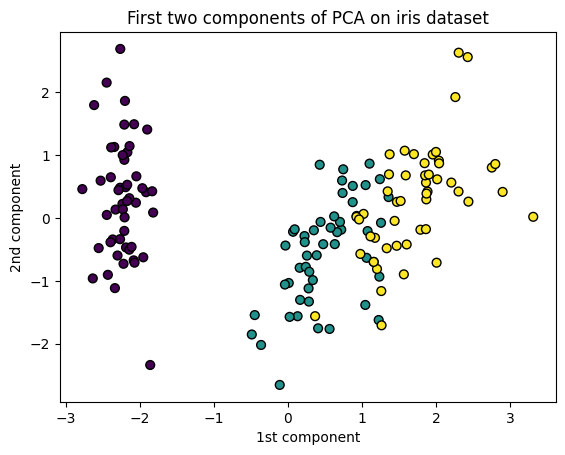

In [7]:
def plot_components(data: np.ndarray, labels: np.ndarray) -> None:
    plt.title("First two components of PCA on iris dataset")
    plt.xlabel("1st component")
    plt.ylabel("2nd component")
    plt.scatter(*data.T, c=labels, edgecolor="k", s=40)
    plt.show()


plot_components(X_transformed, y)

# 3. PCA from scratch

In order to do PCA we need to perform these 3 steps:
1. Scale the data (if necessary)
2. Calculate covariance matrix
3. Eigenvalue decomposition
4. Transform the original data into lower dimensions

## 3.1. Scale the data

As the goal of the algorithm is to reduce the number of dimensions while preserving original variation of the data, if some features have high scale - they will be voted as more important (and we don't want that).

Since I scaled the data right in the beginning we can skip this step.

## 3.2. Covariance matrix

Let's see what is the difference between variance and covariance.

Variance measures variations of a single variable.

Covariance is basically a correlation.</br>
Here is citation from Wiki:
>In probability theory and statistics, covariance is a measure of the joint variability of two random variables. If the greater values of one variable mainly correspond with the greater values of the other variable, and the same holds for the lesser values (that is, the variables tend to show similar behavior), the covariance is positive. In the opposite case, when the greater values of one variable mainly correspond to the fewer values of the other, (that is, the variables tend to show opposite behavior), the covariance is negative.

On the main diagonal of the covariance matrix is a variance, and other values are covariances.

[[ 1.00671141 -0.11835884  0.87760447  0.82343066]
 [-0.11835884  1.00671141 -0.43131554 -0.36858315]
 [ 0.87760447 -0.43131554  1.00671141  0.96932762]
 [ 0.82343066 -0.36858315  0.96932762  1.00671141]]


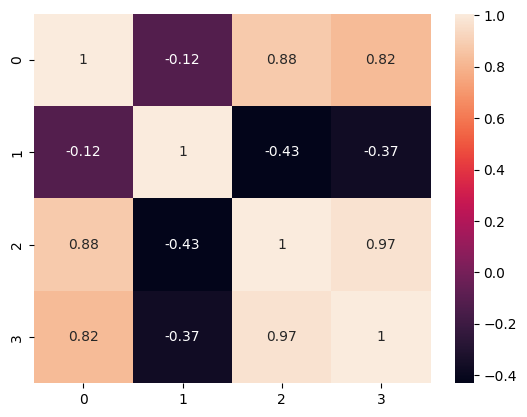

In [8]:
cov_mat = np.cov(X, rowvar=False)
print(cov_mat)
sns.heatmap(cov_mat, annot=True);

## 3.3. Eigenvalues and eigenvectors

Eigenvectors are simple unit vectors and eigenvalues - values of the magnitude of eigenvectors.

From the above we saw that the covariance matrix is symmetrical and it turns out that eigenvectors of symmetric matrices are orthogonal, which is very handy for us. It means that the first component of PCA will explain the most variation of the data. And the first component is orthogonal to the second principal component, which explains most of the remaining variance.

We can use this fact: if first 3 components explains 99% of all variance in the data, that means that we can skip the remaining principal components (dimensions) without loosing any significant amount of data. That's how PCA can also be used for noise reduction.

In [9]:
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

In [10]:
print(f"Variance explained by each component: {eigenvalues / eigenvalues.sum()}")
print(f"Cumulative sum of variances explained: {np.cumsum(eigenvalues / eigenvalues.sum())}")

Variance explained by each component: [0.72962445 0.22850762 0.03668922 0.00517871]
Cumulative sum of variances explained: [0.72962445 0.95813207 0.99482129 1.        ]


From the above we can see that the first component explains ~73% of variance and first 3 components explain ~99%, that means that we can easily drop the last, fourth, component.

To make sure that eigenvalues and corresponding eigenvectors are sorted in descending order by the amount of variance each component explains let's do this:

In [11]:
indices_sorted = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[indices_sorted]
eigenvectors = eigenvectors[indices_sorted]

## 3.4. Transform the data into lower dimensions

In order to transform we simply need to make a dot product between the original data and first n eigenvectors (after we sorted them by explained variance).

In [12]:
X_transformed = X.dot(eigenvectors[:, :N_COMPONENTS])
X_transformed.shape

(150, 2)

As we can see now we indeed have only 2 dimensions.

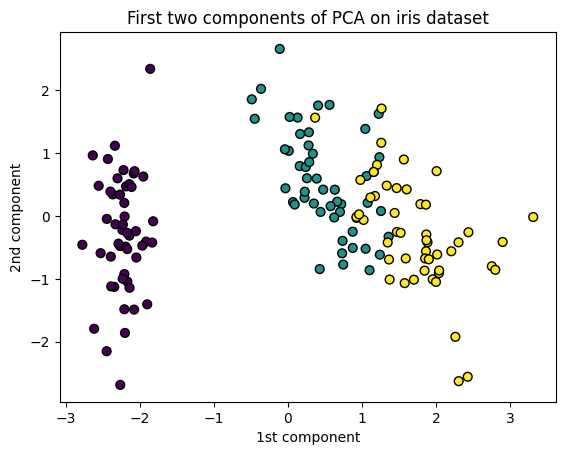

In [13]:
plot_components(X_transformed, y)

## 3.5. PCA from scratch (as a class)

The last step will be create a class that have the sample 'fit', 'transform' and 'fit_transform' methods as in PCA from scikit-learn.

In [14]:
class CustomPCA:
    def __init__(self, n_components: int, standardize_data: bool = True) -> None:
        super().__init__()
        self.n_components = n_components
        self.standardize_data = standardize_data
        if self.standardize_data:
            self.scaler = StandardScaler()

    def fit(self, X: np.ndarray) -> None:
        # standardize data
        if self.standardize_data:
            X = self.scaler.fit_transform(X)

        # calculate covariance matrix
        cov = np.cov(X, rowvar=X.shape[0] < X.shape[1])

        # callable eigen values and vectors from covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        # sort by descending eigen values
        indices = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[indices]
        self.eigenvectors = eigenvectors[indices]

    def transform(self, X: np.ndarray) -> np.ndarray:
        return X.dot(self.eigenvectors[:, : self.n_components])

    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.transform(X)

In [15]:
custom_pca = CustomPCA(N_COMPONENTS)
X_transformed = custom_pca.fit_transform(X)

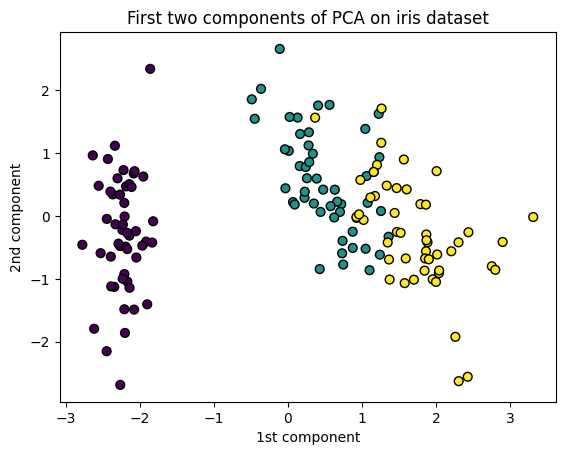

In [16]:
plot_components(X_transformed, y)